<a href="https://colab.research.google.com/github/Flurame/ML4/blob/main/main112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:

# 📦 Импорт библиотек
import os
import re
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_scheduler
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import roc_curve, auc

In [4]:
# 🔧 Фиксация seed для воспроизводимости
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
# 📌 Настройки визуализации и устройства
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
# 📄 Загрузка и очистка данных
DATA_PATH = "data.csv"
assert os.path.exists(DATA_PATH), f"Файл {DATA_PATH} не найден."

df = pd.read_csv(DATA_PATH).drop_duplicates()


In [7]:
# ✅ Очистка текста: оставить только буквы, цифры и смайлики
def clean_text_keep_emojis(text):
    text = str(text).lower()
    text = re.sub(r"[^а-яa-z0-9\s😀-🙏]+", " ", text)
    return re.sub(r"\s+", " ", text).strip()

text_col = 'text' if 'text' in df.columns else df.columns[0]
df['text_clean'] = df[text_col].apply(clean_text_keep_emojis)

# ❌ Удаление пустых строк
df = df[df['text_clean'].astype(bool)].reset_index(drop=True)


In [8]:
# 🏷️ Определение мульти-классовых меток
labels = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен'
]

for label in labels:
    df[label] = df.get(label, 0)

y = df[labels].values


In [9]:
# 🔤 Токенизатор и модель
MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    problem_type="multi_label_classification"
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# 📦 Dataset
class CommentDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.FloatTensor(self.labels[idx])
        return item


In [11]:
# 🔀 Train/Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text_clean'].tolist(), y, test_size=0.2, random_state=42
)

train_dataset = CommentDataset(train_texts, train_labels)
test_dataset = CommentDataset(test_texts, test_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [12]:
# ⚙️ Оптимизатор и Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

In [13]:
# 🧠 Тренировка модели
print("🔄 Начало тренировки...")
model.train()
for epoch in range(epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    print(f"📉 Средняя потеря за эпоху: {total_loss / len(train_loader):.4f}")


🔄 Начало тренировки...

🔁 Epoch 1/3


  0%|          | 0/119 [00:00<?, ?it/s]

📉 Средняя потеря за эпоху: 0.3776

🔁 Epoch 2/3


  0%|          | 0/119 [00:00<?, ?it/s]

📉 Средняя потеря за эпоху: 0.3258

🔁 Epoch 3/3


  0%|          | 0/119 [00:00<?, ?it/s]

📉 Средняя потеря за эпоху: 0.3244


In [14]:
# 💾 Сохранение модели
SAVE_DIR = "./bert_multilabel_model"
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print(f"\n✅ Модель и токенизатор сохранены в: {SAVE_DIR}")



✅ Модель и токенизатор сохранены в: ./bert_multilabel_model


In [15]:
# 🧪 Оценка
print("\n📊 Оценка на тестовой выборке...")
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        probs = torch.sigmoid(outputs.logits)
        all_preds.append(probs.cpu().numpy())
        all_true.append(batch["labels"].cpu().numpy())

preds = np.vstack(all_preds)
true = np.vstack(all_true)
preds_bin = (preds >= 0.5).astype(int)


📊 Оценка на тестовой выборке...


In [16]:
# 📈 Отчет
print("\n🧾 Classification Report:")
print(classification_report(true, preds_bin, target_names=labels))
print(f"\n🎯 ROC-AUC (macro): {roc_auc_score(true, preds, average='macro'):.4f}")


🧾 Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.00      0.00      0.00        49
 Нравится качество выполнения заявки       0.00      0.00      0.00        12
Нравится качество работы сотрудников       0.00      0.00      0.00        16
       Понравилось выполнение заявки       0.00      0.00      0.00        86
                        Вопрос решен       0.00      0.00      0.00       133

                           micro avg       0.00      0.00      0.00       296
                           macro avg       0.00      0.00      0.00       296
                        weighted avg       0.00      0.00      0.00       296
                         samples avg       0.00      0.00      0.00       296


🎯 ROC-AUC (macro): 0.6195


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

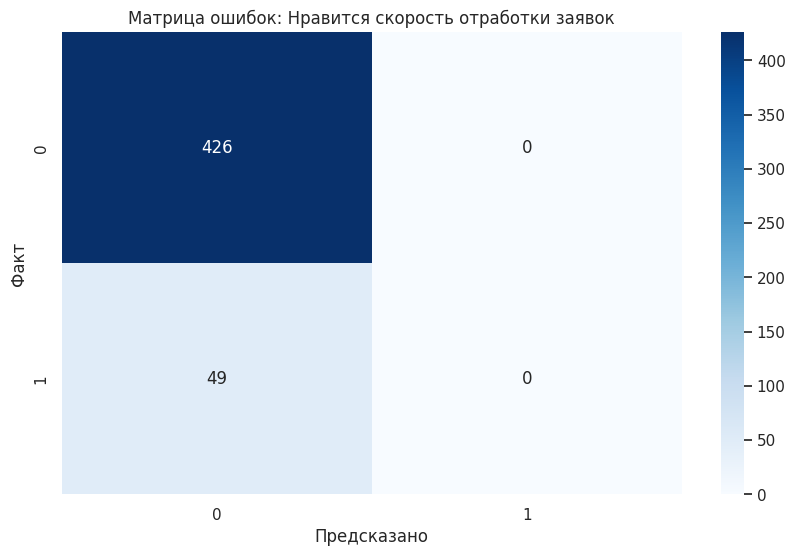

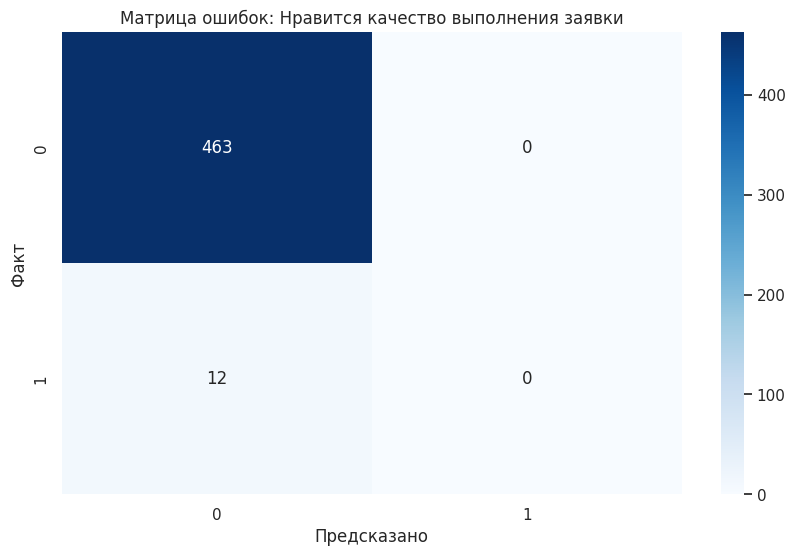

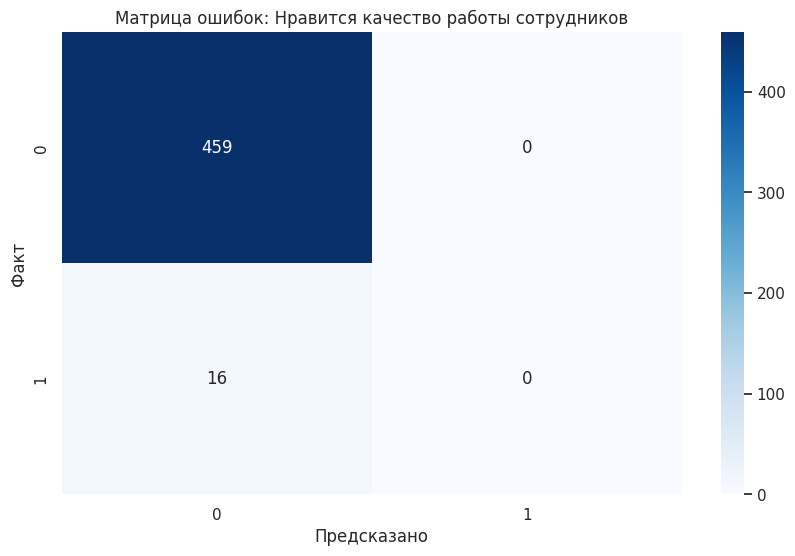

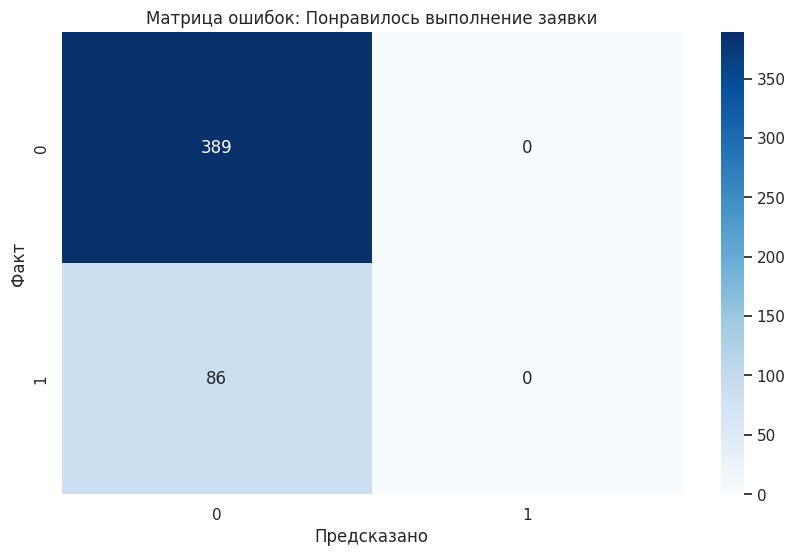

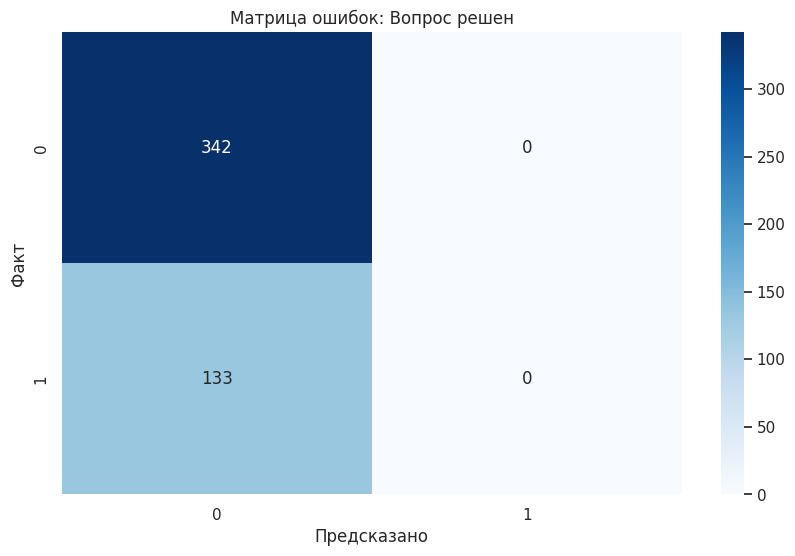

In [17]:
# 🌀 Матрицы ошибок
conf_matrices = multilabel_confusion_matrix(true, preds_bin)
for i, label in enumerate(labels):
    sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Матрица ошибок: {label}")
    plt.xlabel("Предсказано")
    plt.ylabel("Факт")
    plt.show()

In [22]:
for i, label in enumerate(labels):
    true_col = true[:, i].astype(bool)
    pred_col = preds_bin[:, i].astype(bool)

    tp = int((true_col & pred_col).sum())
    fp = int((~true_col & pred_col).sum())
    fn = int((true_col & ~pred_col).sum())

    print(f"\n🔹 Метка: {label}")
    print(f"✅ True Positives: {tp}")
    print(f"❌ False Positives: {fp}")
    print(f"⚠️ False Negatives: {fn}")



🔹 Метка: Нравится скорость отработки заявок
✅ True Positives: 0
❌ False Positives: 0
⚠️ False Negatives: 49

🔹 Метка: Нравится качество выполнения заявки
✅ True Positives: 0
❌ False Positives: 0
⚠️ False Negatives: 12

🔹 Метка: Нравится качество работы сотрудников
✅ True Positives: 0
❌ False Positives: 0
⚠️ False Negatives: 16

🔹 Метка: Понравилось выполнение заявки
✅ True Positives: 0
❌ False Positives: 0
⚠️ False Negatives: 86

🔹 Метка: Вопрос решен
✅ True Positives: 0
❌ False Positives: 0
⚠️ False Negatives: 133


<ipython-input-19-a9d8087d6613>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


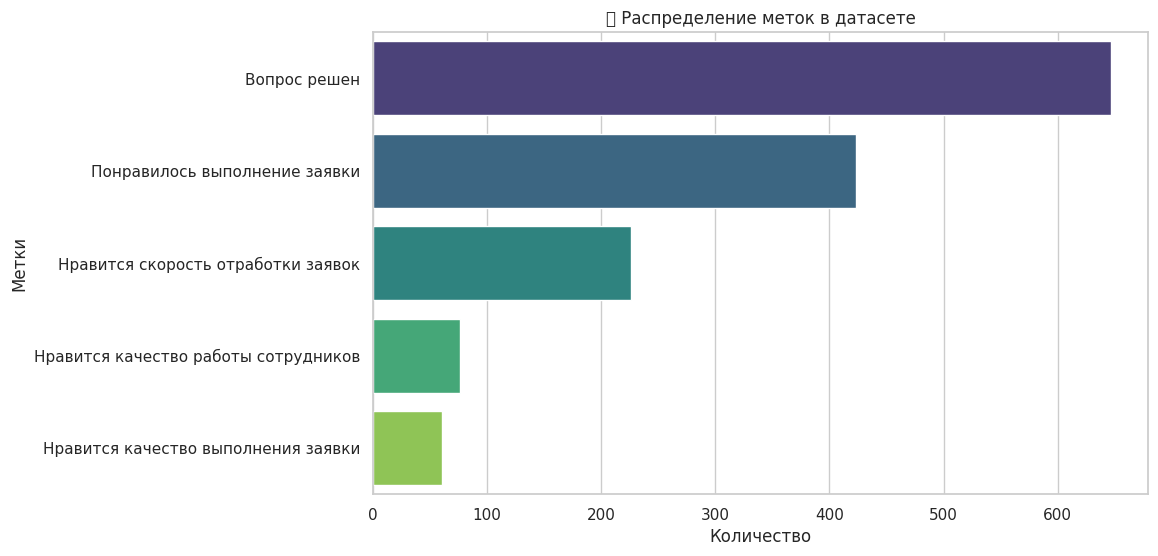

In [19]:
# 📊 1. Распределение меток
label_counts = df[labels].sum().sort_values(ascending=False)
sns.barplot(x=label_counts.values, y=label_counts.index, palette="viridis")
plt.title("🔢 Распределение меток в датасете")
plt.xlabel("Количество")
plt.ylabel("Метки")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


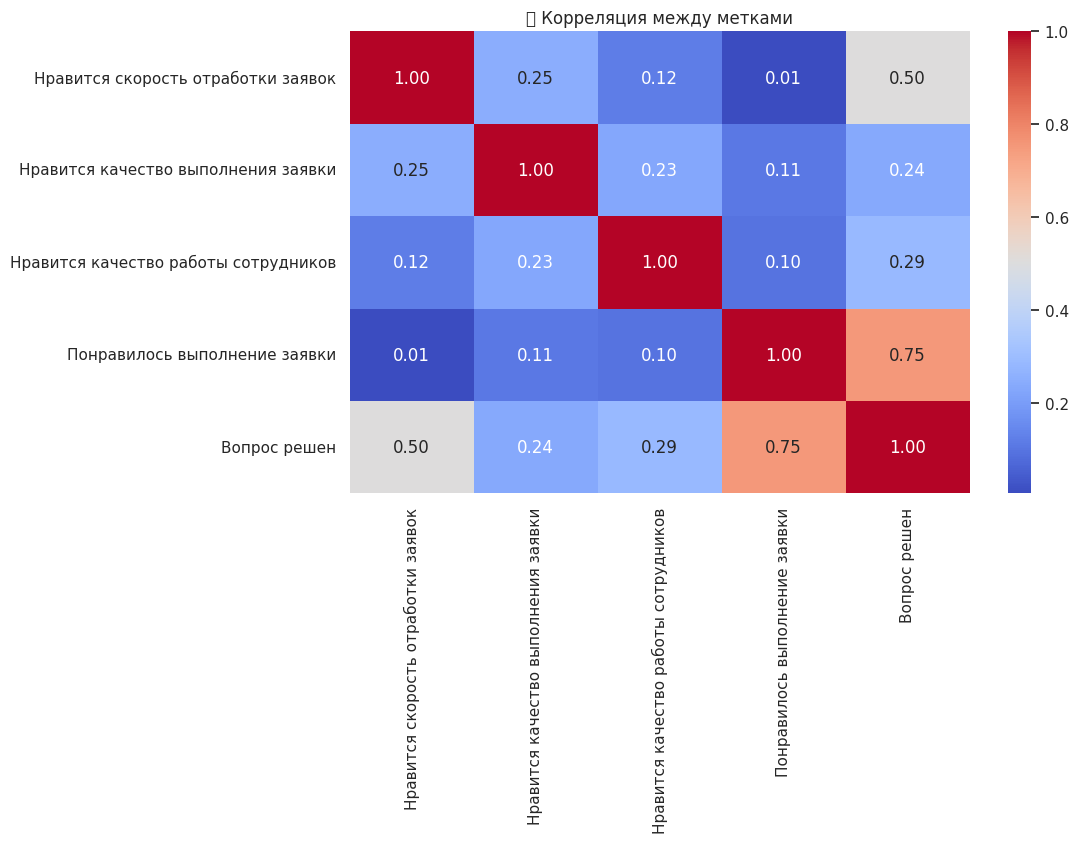

In [20]:
# 🧩 2. Матрица корреляции между метками
corr_matrix = df[labels].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔗 Корреляция между метками")
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


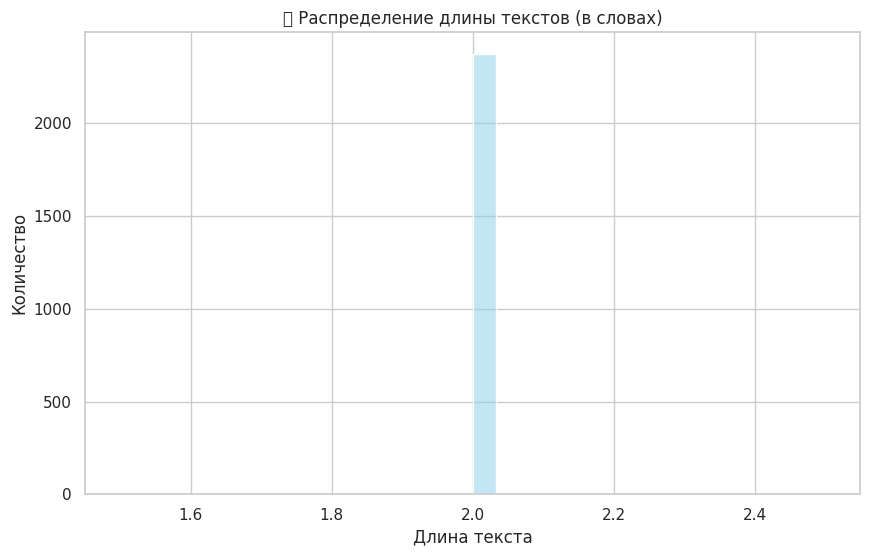

In [21]:
# 📝 3. Распределение длины текстов
text_lengths = df['text_clean'].apply(lambda x: len(x.split()))
sns.histplot(text_lengths, bins=30, kde=True, color="skyblue")
plt.title("📏 Распределение длины текстов (в словах)")
plt.xlabel("Длина текста")
plt.ylabel("Количество")
plt.show()

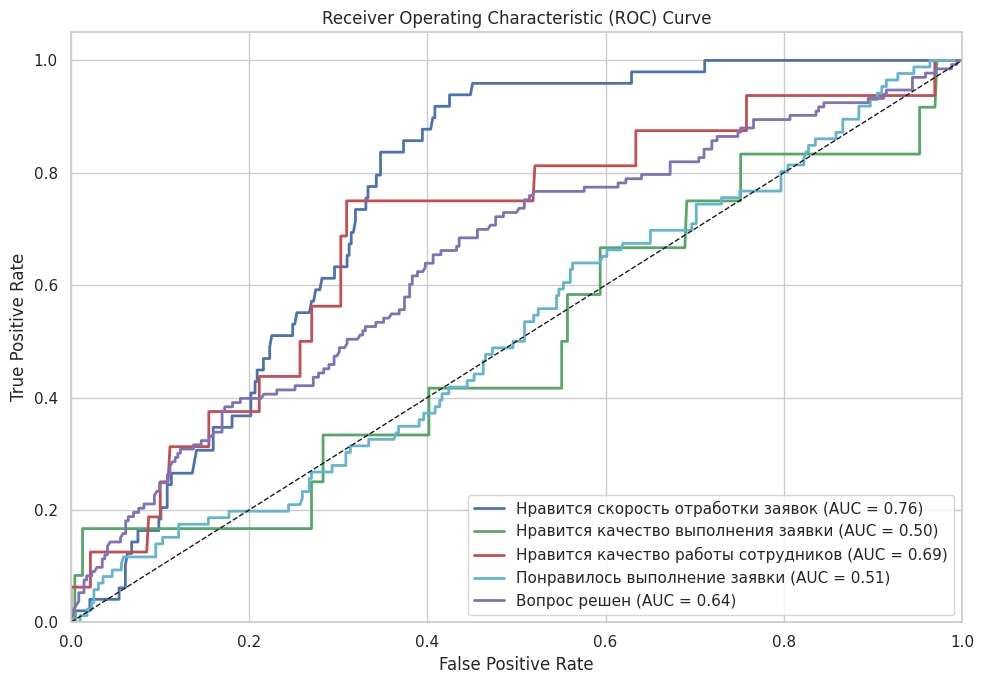

In [24]:
# 🎨 Цвета и стили
colors = ['b', 'g', 'r', 'c', 'm', 'y']
plt.figure(figsize=(10, 7))

# Построение ROC-кривой по каждой метке
for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(true[:, i], preds[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f'{label} (AUC = {roc_auc:.2f})')

# 🔧 Базовая линия и оформление
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()